In [417]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# ml libraries
#from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter #, filtfilt, butter
from collections import deque

#import optuna
#from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
#np.set_printoptions(suppress=True)

# Model serialization
import pickle
import joblib

import serial
import time
import json

In [418]:
# Set requirements
#!pip install -qr ../requirements.txt

In [419]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import add_diff, get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks # 
from utils.figures import get_signals_plot, get_nogo_plot, get_signals_comparison_plot, plot_history, get_nogo, postporocessing_nogo #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
#PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [420]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
#sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [421]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements_2', 'gestures_test_2', 'gestures_train_2', 'gestures_protocol_2', 'gestures_protocol', 'gestures_test', 'gestures_train', 'free_movements'])

### Gestures train and test

In [422]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head(2)

(28976, 65)


0  1   2     3     4     5     6   7  8   9  ...  GYR2  ENC0  ENC1  ENC2  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...    32    37    50    54   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...    31    37    50    54   

   ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
0    44     5     0       0     0  1174956  
1    44     5     0       0     0  1174989  

[2 rows x 65 columns]

In [423]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head(2)

(7244, 65)


0  1   2     3     4     5     6   7  8  9  ...  GYR2  ENC0  ENC1  \
28976  10  9  38  2994  3119  2996  2773  38  9  6  ...    19    25    28   
28977  10  8  35  2989  3117  2996  2766  36  8  6  ...    26    25    28   

       ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
28976    32    17     6     0       0     0  2131164  
28977    32    17     6     0       0     0  2131197  

[2 rows x 65 columns]

```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

In [424]:
# Обозначение колонок для удобства доступа
# [X features] '0', ..., '49' - каналы OMG датчиков
OMG_CH = [str(i) for i in range(50)]

# 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
ACC_CH = config.ACC_CH

# 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
GYR_CH = config.GYR_CH

# [y target] = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5'] - координаты пальцев в перчатке GLOVE
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем

# 'BUTTON' - не используется
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

# Обозначение признаков разницы
col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времен

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

print(gestures_train.shape, gestures_test.shape, mounts['gestures_train_2'].shape, mounts['gestures_test_2'].shape)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
(28976, 65) (7244, 65) (21320, 65) (5330, 65)


### Protocol

In [425]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(11)

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
5        1.0    1.0     0.0   0.0    0.0            0.0            0.0   
6        0.0    0.0     1.0   1.0    1.0            0.0            0.0   
7        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
8        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
9        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
10       0.0    0.0     0.0   0.0    0.0            1.0            1.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
5                 0.0           0.0            0.0        0.0  
6                 0.0           0.0            0.0        0.0  
7                 0.0           0.0            0.0        0.5  
8                 0.0           0.0            0.0        0.5  
9                 0.0           0.0            0.0        0.5  
10                1.0           1.0            1.0        0.5

In [426]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [427]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_train_ext2 = pd.merge(
    mounts['gestures_train_2'],
    mounts['gestures_protocol_2'],
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext2 = pd.merge(
    mounts['gestures_test_2'],
    mounts['gestures_protocol_2'],
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

0  1   2     3     4     5     6   7  8   9  ...  Index  Middle  Ring  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...    0.0     0.0   0.0   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...    0.0     0.0   0.0   
2  16  8  29  2847  2930  2875  2598  24  8   6  ...    0.0     0.0   0.0   
3  10  8  29  2847  2930  2875  2598  25  8   5  ...    0.0     0.0   0.0   
4   0  8  29  2845  2927  2870  2594  24  8   6  ...    0.0     0.0   0.0   

   Pinky  Thumb_stretch  Index_stretch  Middle_stretch  Ring_stretch  \
0    0.0            0.0            0.0             0.0           0.0   
1    0.0            0.0            0.0             0.0           0.0   
2    0.0            0.0            0.0             0.0           0.0   
3    0.0            0.0            0.0             0.0           0.0   
4    0.0            0.0            0.0             0.0           0.0   

   Pinky_stretch  Pronation  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  

[5 rows x 76 columns]

In [428]:
gestures_train['ts'].head()

0    1174956
1    1174989
2    1175022
3    1175055
4    1175088
Name: ts, dtype: int64

In [429]:
mounts['free_movements'].head(2)

0  1   2     3     4     5     6   7  8  9  ...  GYR2  ENC0  ENC1  ENC2  \
0   5  6  24  2793  2838  2871  2635  28  5  5  ...    34    26    37    45   
1  10  8  29  2829  2859  2877  2640  29  8  6  ...    35    26    37    46   

   ENC3  ENC4  ENC5  BUTTON  SYNC      ts  
0    33    21     0       0     5  434007  
1    33    21     0       0     5  434040  

[2 rows x 65 columns]

## Composition of X_train

In [430]:
X_train_1, X_test_1 = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', pd.DataFrame(X_train_1, columns=OMG_CH).head(2))

y_train_1, y_test_1 = gestures_train[GLOVE_CH].values, gestures_test[GLOVE_CH].values

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', pd.DataFrame(y_train_1, columns=GLOVE_CH).head(2) )#'y_test', y_test.head(2)

'X_train'

0  1   2     3     4     5     6   7  8   9  ...  40  41  42  43  44  45  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...  33  31  11  12   8   5   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...  32  28  10  11   8   5   

   46  47  48  49  
0   8  15  36  33  
1   8  13  32  25  

[2 rows x 50 columns]

'y_train'

ENC0  ENC1  ENC2  ENC3  ENC4
0    37    50    54    44     5
1    37    50    54    44     5

In [431]:
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [432]:
gestures_test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

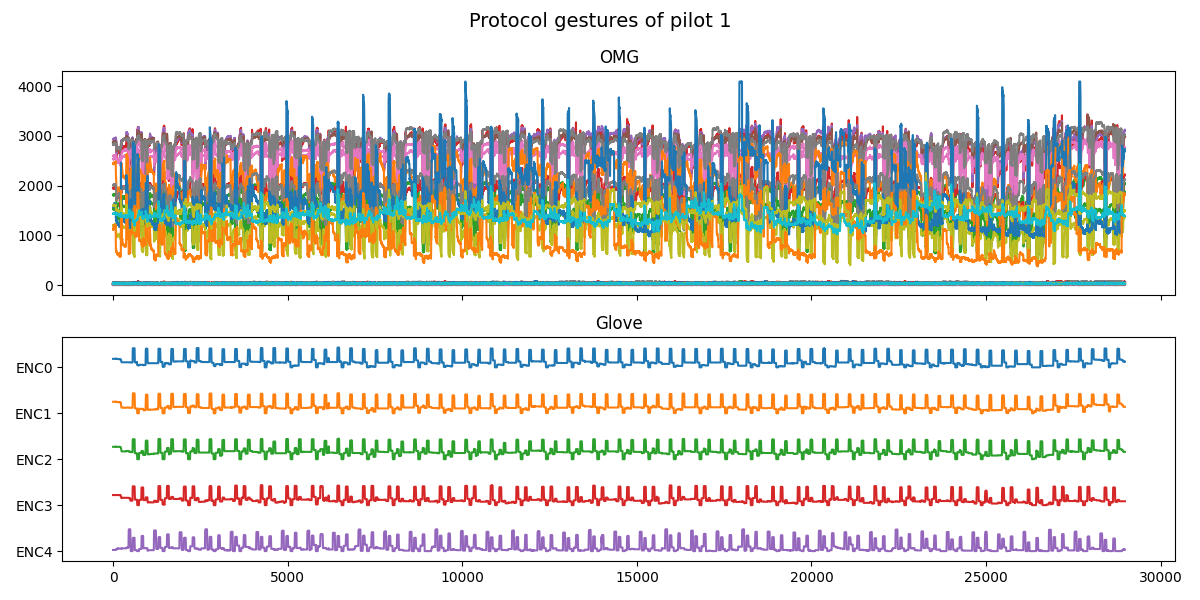

In [433]:
get_signals_plot(X_train_1, y_train_1, title='Protocol gestures of pilot 1')

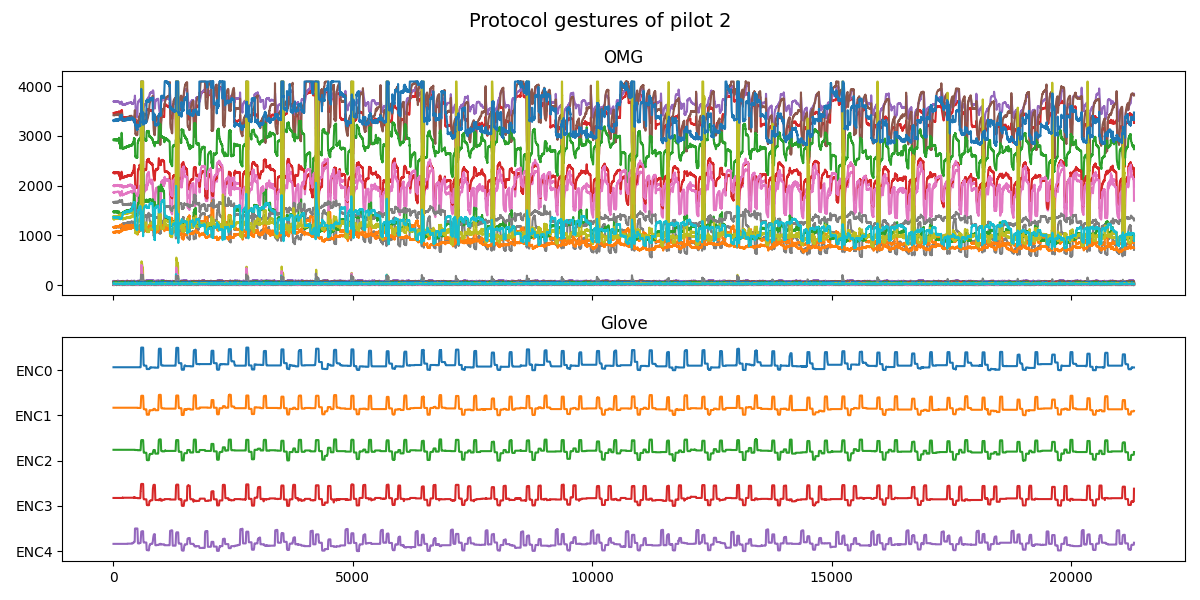

In [434]:
X_train_2, X_test_2 = mounts['gestures_train_2'][OMG_CH].values, mounts['gestures_test_2'][OMG_CH].values #56

y_train_2, y_test_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
get_signals_plot(X_train_2, y_train_2, title='Protocol gestures of pilot 2')

In [435]:
# Combine 2 pilots data
X_train_acc_1, X_train_acc_2 = mounts['gestures_train'][ACC_CH].values, mounts['gestures_train_2'][ACC_CH].values #56
X_train_prn_1, X_train_prn_2 = gestures_train_ext['Pronation'].values, gestures_train_ext2['Pronation'].values
X_train_gyr_1, X_train_gyr_2 = mounts['gestures_train'][GYR_CH].values, mounts['gestures_train_2'][GYR_CH].values

#gestures_test_ext['Pronation'].values

X_train_acc = np.concatenate((X_train_acc_1,  X_train_acc_2), axis=0) 
#gestures_test_ext['Pronation'].values,, gestures_test_ext2['Pronation'].values
X_train_prn = np.concatenate((X_train_prn_1, X_train_prn_2), axis=0)
X_train_gyr = np.concatenate((X_train_gyr_1, X_train_gyr_2), axis=0) 
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

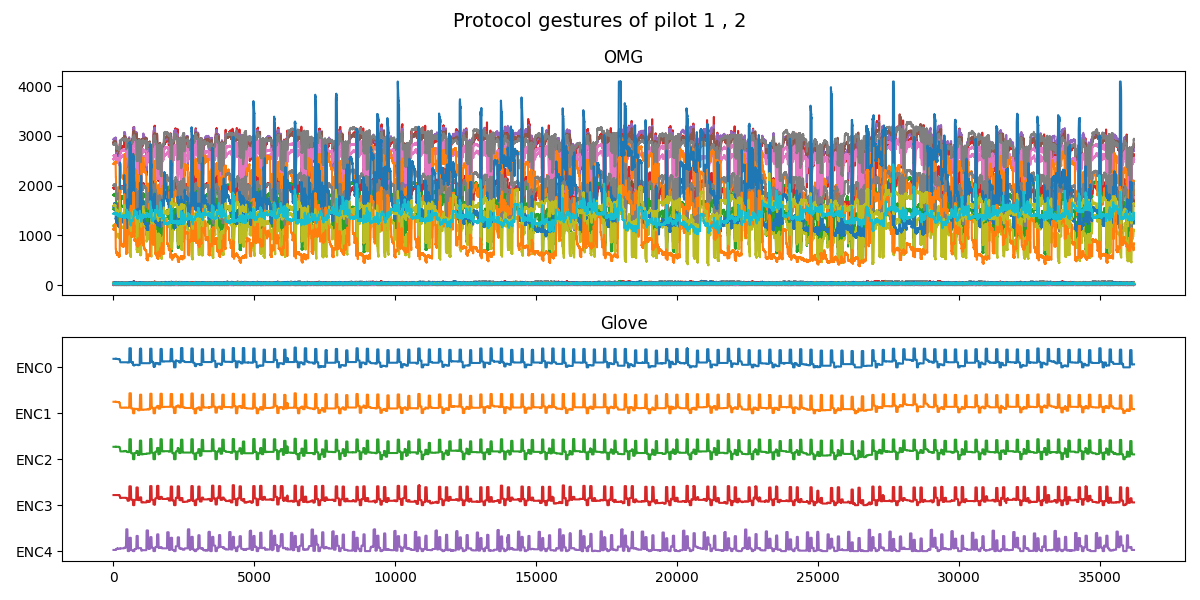

In [436]:
X_train = np.concatenate((X_train_1, X_test_1), axis=0)
y_train = np.concatenate((y_train_1, y_test_1), axis=0)
get_signals_plot(X_train, y_train, title='Protocol gestures of pilot 1 , 2')

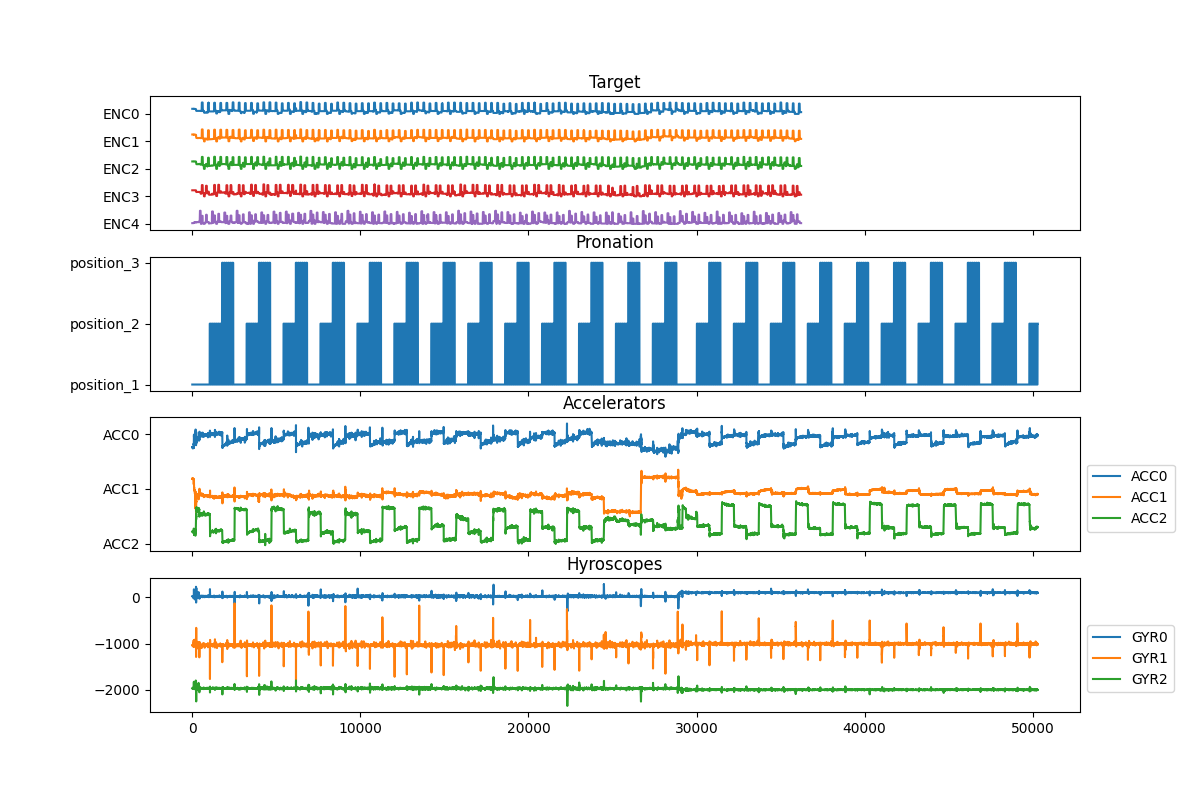

In [437]:
dist = -np.arange(3) * 300
dist1 = -np.arange(5)* 200
dist2 = -np.arange(3) * 1000

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8)) # plt.sca(axes)
ax[0].plot(y_train+dist1)
ax[0].set_title('Target')
ax[0].yaxis.set_ticks(dist1, GLOVE_CH)

ax[1].plot(X_train_prn)
ax[1].set_title('Pronation')
ax[1].yaxis.set_ticks(np.linspace(0,1,3), ['position_1', 'position_2', 'position_3'])

ax[2].plot(X_train_acc+dist)
ax[2].yaxis.set_ticks(dist, ACC_CH)
ax[2].legend(ACC_CH, bbox_to_anchor=(1, 0.7))
ax[2].set_title('Accelerators')

ax[3].plot(X_train_gyr + dist2)
ax[3].set_title('Hyroscopes')
ax[3].legend(GYR_CH, bbox_to_anchor=(1, 0.7));

#plt.show()

#gestures_train[ACC_CH].head(2)

In [438]:
# Pronat = pd.get_dummies(gestures_protocol['Pronation'], prefix='Pronation')
# gestures_protocol = pd.concat([gestures_protocol, Pronat], axis=1)
# gestures_protocol.drop(['Pronation'], axis=1, inplace=True)

# # Features list
# PRON = ['Pronation_0.0', 'Pronation_0.5', 'Pronation_1.0']

# gestures_protocol.head(2)

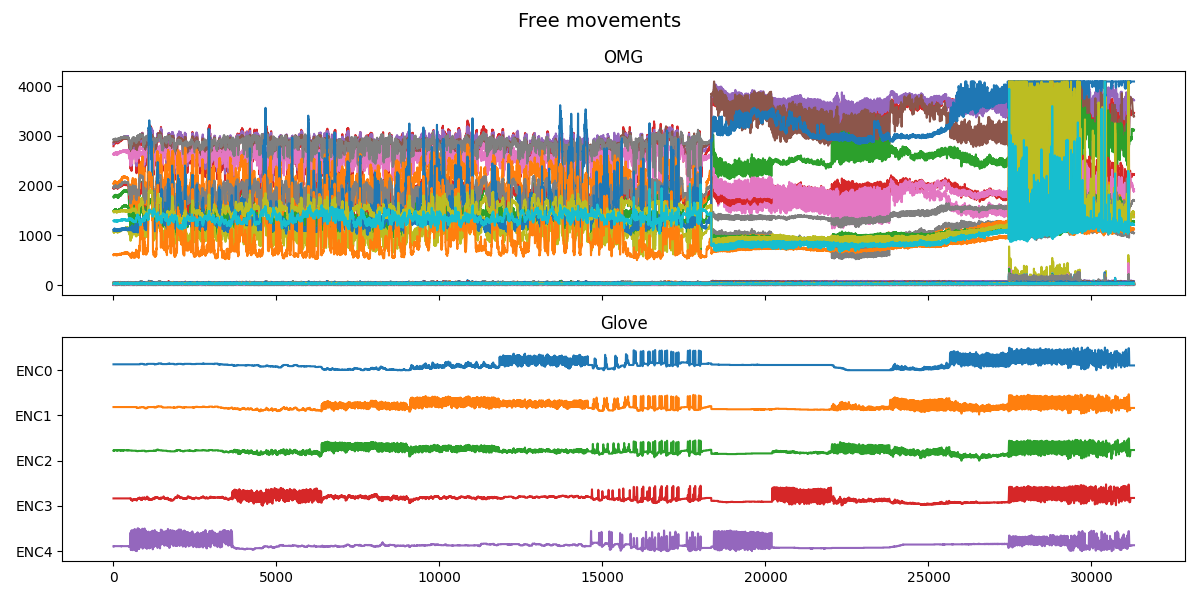

In [439]:
# Combine 2 pilots data
X_free_1, y_free_1 = mounts['free_movements'][OMG_CH].values, mounts['free_movements'][GLOVE_CH].values
X_free_2, y_free_2 = mounts['free_movements_2'][OMG_CH].values, mounts['free_movements_2'][GLOVE_CH].values

X_free_raw, y_free_raw =  np.concatenate((X_free_1, X_free_2), axis=0), np.concatenate((y_free_1, y_free_2), axis=0)

get_signals_plot(X_free_raw, y_free_raw, title='Free movements')
#display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

In [440]:
# Проверка есть ли отрицательные скорости в датасете
mask = mounts['gestures_train']['ACC0'] < 0
mounts['gestures_train'][mask][ACC_CH].head(2)

ACC0  ACC1  ACC2
0   -71    56    67
1   -71    56    68

# Preprocessing

In [441]:
# Combine 2 pilots data
X_train_raw, X_test_raw = np.concatenate((X_train_1, X_train_2), axis=0), np.concatenate((X_test_1, X_test_2), axis=0)
y_train, y_test = np.concatenate((y_train_1, y_train_2), axis=0), np.concatenate((y_test_1, y_test_2), axis=0)

In [442]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# dist = - np.arange(5) * 200
# plt.plot(y_train + dist)
# ax.yaxis.set_ticks(dist, labels=GLOVE_CH)

# plt.suptitle('Signals smoothing')
# plt.grid()

In [443]:
# # Smoothing of sensor 0 signal
# temp = pd.DataFrame({
#     'original':X_train_raw[:1000,3], 
#     'Savitsky golay filter':np.round(X_train[:1000,3]), 
#     #'digital filter':X_train.iloc[:,0]
# })

# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# sns.lineplot(temp)
# plt.suptitle('Signals smoothing')
# plt.grid()

In [444]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test, = scaler.fit_transform(X_train_raw), scaler.transform(X_test_raw) 
#X_free =, scaler.transform(X_free)


#display(pd.DataFrame(X_train, columns=COLS).head(1))

joblib.dump(scaler, os.path.join(config.PATH_MODEL, "MinMax_scaler"+'.bin'), compress=True) 

['../models/MinMax_scaler.bin']

In [445]:
# Add differential values
X_train, X_test  = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5) #, X_free, add_diff(X_free_raw, shift_=5)

In [446]:
# Smoothing of sensor signals
X_train = np.transpose([savgol_filter(X_train[:,i], window_length=5, polyorder=2) for i in range(X_train.shape[1])]) 
X_test = np.transpose([savgol_filter(X_test[:,i], window_length=5, polyorder=2) for i in range(X_test.shape[1])])

In [30]:
# # Read config
# with open('../config/data_config.json', mode='r', encoding='utf-8') as config_file:
#     cfg = json.load(config_file)
    
#     # add new entrie
#     cfg.update(scaler_name="MinMax_scaler.bin")

# # write config
# with open('../config/data_config.json', mode='w') as f:   
#     f.write(json.dumps(cfg, indent=2))

## NOGO

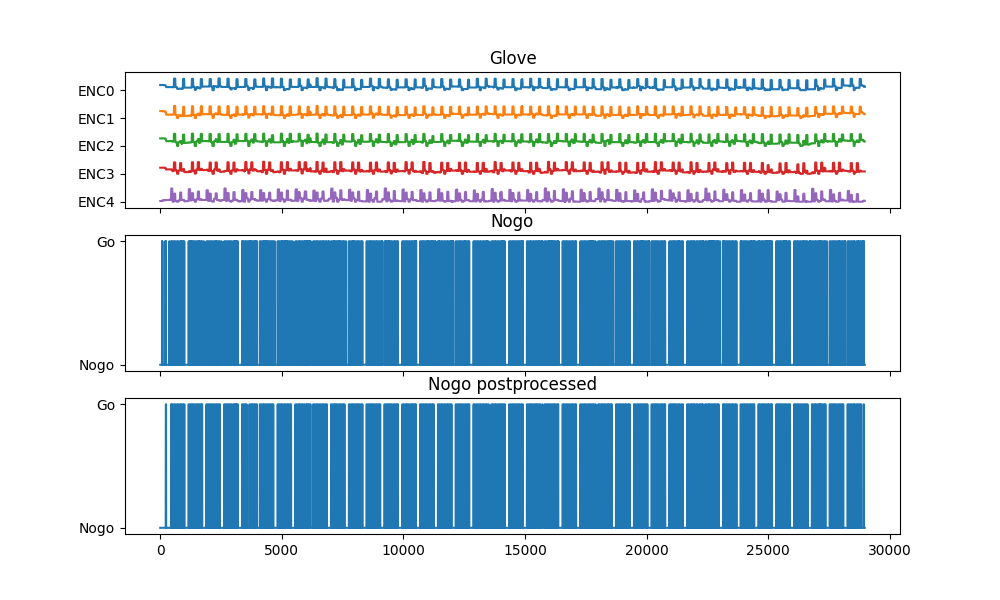

In [391]:
get_nogo_plot(y_train_1, (0, 28970))

In [ ]:
# Concatenation of 2 pilots' accelerators data 
X_train_ac_1, X_test_ac_1 = mounts['gestures_train'][ACC_CH].values, mounts['gestures_test'][ACC_CH].values
X_train_ac_2, X_test_ac_2 = mounts['gestures_train_2'][ACC_CH].values, mounts['gestures_test_2'][ACC_CH].values
X_free_ac_1, X_free_ac_2 = mounts['free_movements'][ACC_CH].values, mounts['free_movements_2'][ACC_CH].values

#X_train_ag, X_test_ag, X_free_ag = np.concatenate((X_train_ag_1, X_train_ag_2), axis=0), np.concatenate((X_test_ag_1, X_test_ag_2), axis=0), np.concatenate((X_free_ag_1, X_free_ag_2), axis=0)

X_train_ac = np.concatenate((X_train_ac_1, X_test_ac_1, X_train_ac_2, X_test_ac_2, X_free_ac_1, X_free_ac_2), axis=0)[1:]
X_train_ac.shape

(94176, 3)

In [ ]:
y_train_ac_1, y_test_ac_1 = mounts['gestures_train'][GLOVE_CH].values, mounts['gestures_test'][GLOVE_CH].values
y_train_ac_2, y_test_ac_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
y_free_ac_1, y_free_ac_2 = mounts['free_movements'][GLOVE_CH].values, mounts['free_movements_2'][GLOVE_CH].values

y_train_ac = np.concatenate((y_train_ac_1, y_test_ac_1, y_train_ac_2, y_test_ac_2, y_free_ac_1, y_free_ac_2), axis=0)
y_train_ac.shape

(94177, 5)

In [ ]:
y_train_ac_post = postporocessing_nogo(get_nogo(y_train_ac))
y_train_ac_post.shape

(94176,)

In [ ]:
#y_train_post, y_test_post, y_free_post = postporocessing_nogo(get_nogo(y_train)), postporocessing_nogo(get_nogo(y_test)), postporocessing_nogo(get_nogo(y_free_raw))

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_ac_scaled = scaler.fit_transform(X_train_ac)
X_train_ac_scaled.shape
#y_train, y_test = np.c_[y_train_ag, np.r_[np.zeros(1), y_train_ag]], np.c_[y_test_ag, np.r_[np.zeros(1), y_test_ag]]
#y_train_ag, y_test_ag, y_free_ag = np.r_[np.zeros(1), y_train_post], np.r_[np.zeros(1), y_test_post], np.r_[np.zeros(1), y_free_post]

# Shape : (50296, 50)
#X_train_raw.shape 

(94176, 3)

In [ ]:
#get_nogo_plot(y_free_raw, (0, 17500))

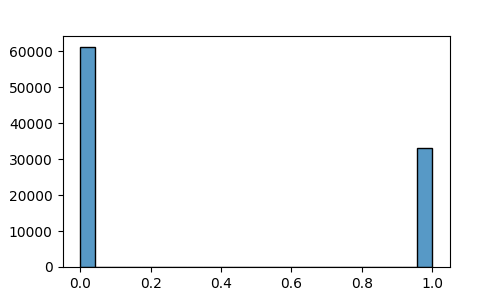

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3)) 
sns.histplot(y_train_ac_post)
plt.show()

In [ ]:
y_train_ac_post

In [ ]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train_ac_scaled, y_train_ac_post, test_size=0.2,  random_state=seed_value)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=seed_value)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (75340, 3)
Test shape:  (9418, 3)
Valid shape: (9418, 3)


In [ ]:

#X_test_ag, X_valid_ag, y_test_ag, y_valid_ag  = train_test_split(X_test_ag, y_test_ag, test_size=0.5, random_state=seed_value)

log_reg = LogisticRegression(
    #solver='sag', 
    #max_iter=70,
    random_state=seed_value)

# Model training
log_reg.fit(X_train, y_train) 

# Prediction of target values
y_pred = log_reg.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.95      0.78      6148
           1       0.47      0.08      0.14      3270

    accuracy                           0.65      9418
   macro avg       0.56      0.52      0.46      9418
weighted avg       0.59      0.65      0.56      9418



In [ ]:
# # Prediction of free_movements values
# y_pred1 = log_reg.predict(X_free_ag)
# # Metrics report
# print(classification_report(y_free_ag, y_pred1))

              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40      7889
         1.0       0.00      0.00      0.00     23418

    accuracy                           0.25     31307
   macro avg       0.13      0.50      0.20     31307
weighted avg       0.06      0.25      0.10     31307



# Modeling

### Linear regression

In [ ]:
# # для Nogo
# y_train_ac_1, y_test_ac_1 = mounts['gestures_train'][GLOVE_CH].values, mounts['gestures_test'][GLOVE_CH].values
# y_train_ac_2, y_test_ac_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
# y_free_ac_1, y_free_ac_2 = mounts['free_movements'][GLOVE_CH].values, mounts['free_movements_2'][GLOVE_CH].values

# y_train_ac = np.concatenate((y_train_ac_1, y_test_ac_1, y_train_ac_2, y_test_ac_2, y_free_ac_1, y_free_ac_2), axis=0)
# y_train_ac.shape

# X_train_ag, X_test_ag, = np.concatenate((X_train_ag_1, X_train_ag_2), axis=0), np.concatenate((X_test_ag_1, X_test_ag_2), axis=0)
# #X_train, X_test = np.c_[X_train, log_reg.predict(X_train_ag)], np.c_[X_test, log_reg.predict(X_test_ag)]

# y_train_post, y_test_post, y_free_post = postporocessing_nogo(get_nogo(y_train)), postporocessing_nogo(get_nogo(y_test)), postporocessing_nogo(get_nogo(y_free_raw))

# #y_train, y_test = np.c_[y_train_ag, np.r_[np.zeros(1), y_train_ag]], np.c_[y_test_ag, np.r_[np.zeros(1), y_test_ag]]
# y_train_ag, y_test_ag, y_free_ag = np.r_[np.zeros(1), y_train_post], np.r_[np.zeros(1), y_test_post], np.r_[np.zeros(1), y_free_post]

# # Shape : (50296, 50)
# #X_train_raw.shape 

(94177, 5)

Test
ENC0  128.073332
ENC1   93.137763
ENC2  101.242461
ENC3  128.087561
ENC4  265.056039

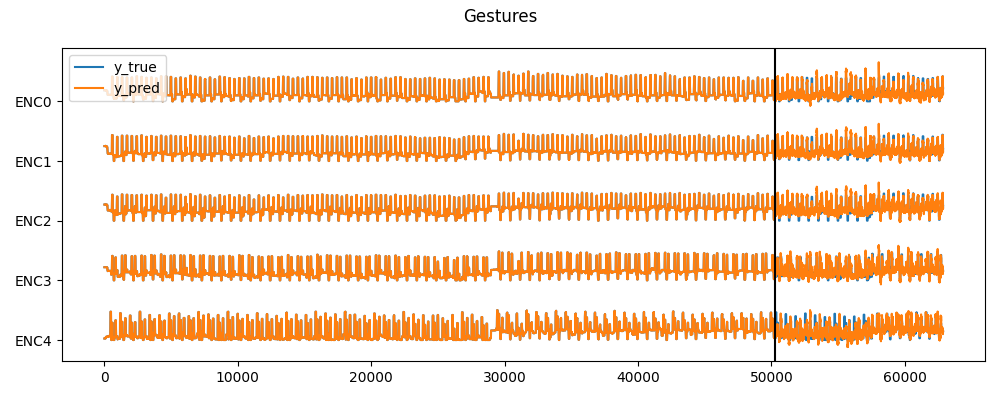

In [55]:
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train)

# Predict target values
y_pred = lin.predict(X_test)#.round() 
 
# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

In [ ]:
# Save model to the given path in the pkl format
model_name = 'lin'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(lin, f)

### Линейная регрессия в Numpy

In [459]:
def get_weight(X, y):
    """_вычислятель коэффициентов (весов) линейной регрессии_
    """              
    return np.linalg.inv(X.T @ X) @ X.T @ y

weights = get_weight(X_train, y_train)

def get_predict(X, weights):

    return X @ weights

y_pred_train = get_predict(X_train, weights)
y_pred = get_predict(X_test, weights)

# Display metrics
get_mse(y_test, y_pred)

Test
ENC0  129.974381
ENC1   93.544331
ENC2  103.357748
ENC3  131.668679
ENC4  265.566678

In [ ]:
# prev = None
# for i in range(1, len(y_pred)):
#     y_postprocessed = postprocessing(y_pred[i], prev)
    
#     y_dct['sample_preprocessed'].append(sample_preprocessed)

In [56]:
preproc_coef = 0.57
prev = None

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred)
y_pred_test_proc[0] = y_pred[0]


for i in range(1, len(y_pred)):
    y_pred_test_proc[i] = postprocessing(y_pred[i], y_pred[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

Test
ENC0  123.405281
ENC1   88.063544
ENC2   94.860267
ENC3  124.825990
ENC4  259.966598

### XGb

Test
ENC0  116.951579
ENC1   65.054954
ENC2   60.484251
ENC3   57.038965
ENC4  160.077521

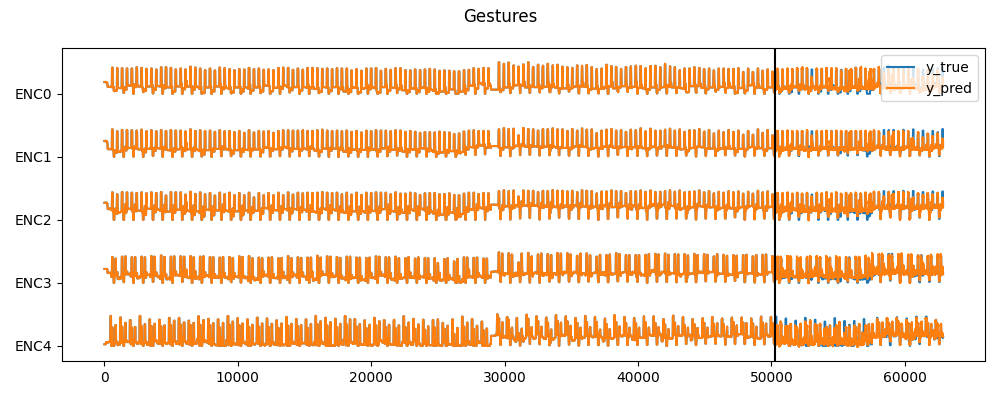

In [ ]:
# параметры оптимизированы optun'ой
params = {'learning_rate': 0.06329973864656831,
 'max_depth': 6,
 'subsample': 0.9814063371832862,
 'colsample_bytree': 0.41087811860602663,
 'min_child_weight': 8}

# Creation an instance
model_xgb = xgb.XGBRegressor(**params)

# Train the Model
model_xgb.fit(X_train, y_train)
 

# Predict target values
y_pred = model_xgb.predict(X_test)#.round() 
 
# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

#### Сравнение моделей

In [ ]:
# Save model to the given path in the pkl format
model_name = 'xgb'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(model_xgb, f)

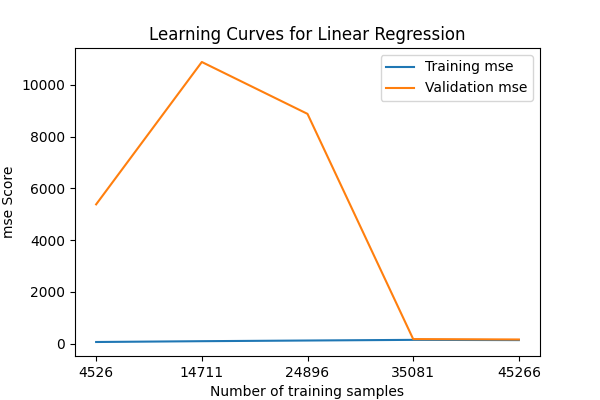

In [ ]:
# from sklearn.model_selection import learning_curve 

# # Split data into training and validation sets
# train_sizes, train_scores, test_scores = learning_curve(lin, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# # Plot the learning curves
# fig, ax = plt.subplots(1,1, figsize=(6,4))
# plt.plot(train_sizes, np.mean(-train_scores, axis=1), label='Training mse')
# plt.plot(train_sizes, np.mean(-test_scores, axis=1), label='Validation mse')
# plt.xlabel('Number of training samples')
# plt.ylabel('mse Score')
# plt.title('Learning Curves for Linear Regression')
# ax.xaxis.set_ticks(train_sizes)
# #Устаналиваем диапазон оси ординат
# #ax.set_ylim(0, 1)
# plt.legend();


### Нейронные сети

In [31]:
reset_random_seeds(seed_value)

#np.expand_dims(X_train, axis=0).shape

n_timesteps = None
b_size = 64
n_channels = X_train.shape[1] # gestures_train[[*OMG_CH, *ACC_CH, *GYR_CH]].shape[1] 
output_units = y_train.shape[1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(units=100, 
                         recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
                         )(x) 
x = tf.keras.layers.Dropout(0.3)(x) #0.3
output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001) #learning_rate=0.001
    )

callbacks_list = callbacks(1e-03)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 batch_normalization (BatchN  (None, None, 100)        400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-trainable params: 200
__________________________________________________

In [32]:
history = model.fit(
            x = np.expand_dims(X_train, 1),
            y = y_train,
            batch_size=b_size,
            validation_split=0.2,
            epochs=1500,
            verbose=1,          
            callbacks=callbacks_list
        )
clear_output(wait=False)

In [45]:
#plot_model(model)

In [55]:
# Save LSTM model
#model.save(os.path.join(config.PATH_MODEL, model.name))

INFO:tensorflow:Assets written to: ../models/model_LSTM\assets


INFO:tensorflow:Assets written to: ../models/model_LSTM\assets


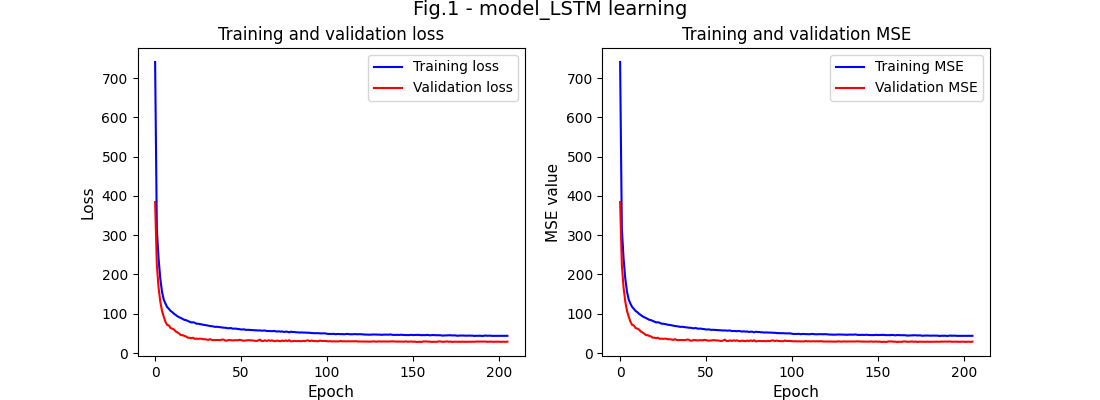

In [33]:
plot_history(history, model.name)

### Prediction

393/393 [==============================] - 1s 1ms/step


Test
ENC0  47.319481
ENC1  22.506703
ENC2  29.551782
ENC3  38.597707
ENC4  99.151633

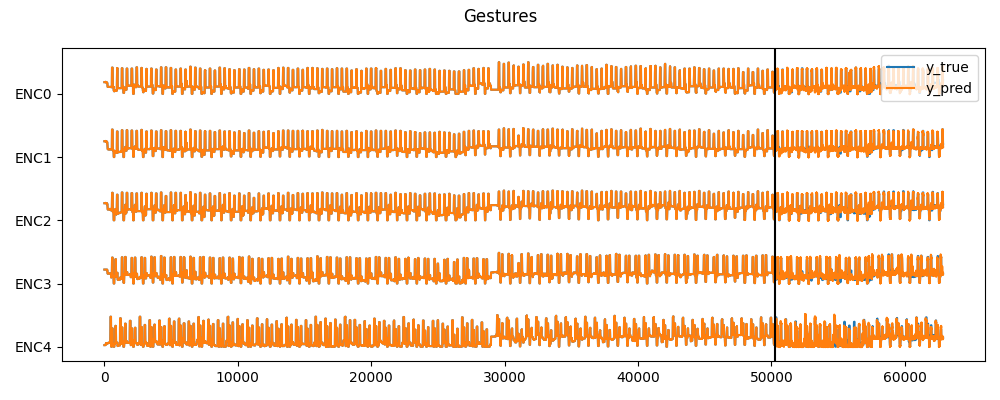

In [34]:
y_pred_train = model.predict(np.expand_dims(X_train, 1)) # [*OMG_CH, *ACC_CH, *GYR_CH] 
#y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train['ts'])

y_pred_test = model.predict(np.expand_dims(X_test, 1)) #[*OMG_CH, *ACC_CH, *GYR_CH]
#y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred_test)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_test, only_test=1)

### Model_stateful

In [62]:

# model  for inference
n_channels = X_train.shape[1]
n_timesteps = None

output_units = y_train.shape[1]
hidden_size = 100

model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))

x = tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
    # return_state=True,
    # last state for each sample at index i in a batch will be used 
    # as initial state for the sample of index i in the following batch
    stateful=True,
    # speed-up a RNN, but more memory-intensive.
    # only suitable for short sequences.
    unroll=True
)(x)

#x = tf.keras.layers.Dropout(0.3)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

# # Загрузка модели из памяти
model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# Загрузка весов из памяти
#model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'best_model.hdf5'))

model_stateful.set_weights(model.get_weights())

model_stateful.summary()

Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 100)]             0         
                                                                 
 batch_normalization_3 (Batc  (1, 1, 100)              400       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, 1, 100)               80400     
                                                                 
 time_distributed_3 (TimeDis  (1, 1, 5)                505       
 tributed)                                                       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-trainable params: 200
_________________________________________________________________


In [215]:
# Test single prediction on the real data entry after MinMaxScaler
check_data = X_train[430]#.copy()

check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)
print('after reshaping:', check_data.shape) # after reshaping: (1, 1, 100)

#y_pred = model_stateful(check_data, training=False)#.round(2)
y_pred = model_stateful.predict(check_data).round()
print(y_pred.shape)
y_pred[0][0]

after reshaping: (1, 1, 100)
1/1 [==============================] - 0s 21ms/step
(1, 1, 5)


array([ 8., 21., 37., 61., 68.], dtype=float32)

In [176]:
# # Считает более 12 минут!
# #
# #
# #

# check_data = X_test[420:450].copy()
# y_pred_stateful = []
# #ss = list()
# #check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)

# for i in range(check_data.shape[0]):
#     x = np.expand_dims(np.expand_dims(check_data[i,:], 0), 0)
#     #ss.append(x)
#     y_pred = model_stateful.predict(x).round()
#     y_pred_stateful.append(y_pred[0][0])#
    
#     #y_pred = model_stateful(x, training=False)
#     #y_pred_stateful.append(y_pred.numpy()[0][0])#

# y_pred_stateful = np.vstack(y_pred_stateful)#[0][0]
# clear_output(wait=False)

# y_pred_stateful.shape

(12574, 5)

In [ ]:
check_data = X_test[420:450].copy()
y_pred_stateful = []

#check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)

for i in range(check_data.shape[0]):
    x = np.expand_dims(np.expand_dims(check_data[i,:], 0), 0)
    y_pred = model_stateful.predict(x).round()
    y_pred_stateful.append(y_pred[0][0])#
    
    #y_pred = model_stateful(x, training=False)
    #y_pred_stateful.append(y_pred.numpy()[0][0])#

y_pred_stateful = np.vstack(y_pred_stateful)#[0][0]
clear_output(wait=False)

Test
ENC0  148.877764
ENC1  142.594481
ENC2  201.230476
ENC3  216.923334
ENC4  262.127008

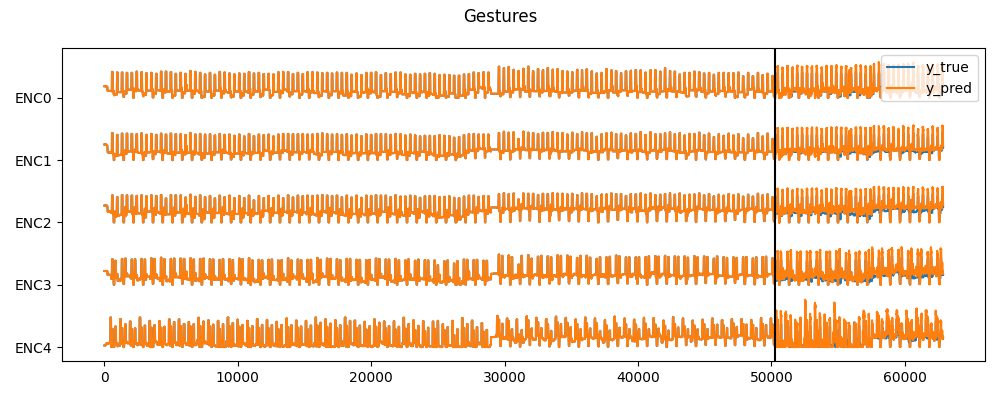

In [177]:
# Display metrics
get_mse(y_test, y_pred_stateful)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_stateful, only_test=1)

In [178]:
preproc_coef = 0.57
prev = None

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

y_pred = y_pred_stateful
# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred)
y_pred_test_proc[0] = y_pred[0]


for i in range(1, len(y_pred)):
    y_pred_test_proc[i] = postprocessing(y_pred[i], y_pred[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

Test
ENC0  140.082551
ENC1  130.555909
ENC2  171.523382
ENC3  186.913075
ENC4  224.189200

In [ ]:

# real data
check_data = X_train[:10000]#.copy()
check_data = np.expand_dims(check_data, 0)
len_check_data = check_data.shape[1]

# predict by model.predict
y_pred = model.predict(check_data)
print(y_pred.shape)


model_stateful.reset_states()
y_pred_stateful = []
for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
 
y_pred_stateful = np.hstack(y_pred_stateful)

# CHECK equality of predictions
# ALL
print(np.allclose(y_pred, y_pred_stateful, atol=0.000001))

# EACH ONE
np.isclose(y_pred, y_pred_stateful).sum() / np.prod(y_pred_stateful.shape)

In [ ]:
%%time

model_stateful.reset_states()

y_pred_stateful = []

time_start = time.time()

for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
    
time_end = time.time()
ts = (time_end - time_start) / len_check_data
    
y_pred_stateful = np.hstack(y_pred_stateful)

print(f"Avg time of {len_check_data} iters: {ts:.4f}")
print(y_pred_stateful.shape)
# y_pred_stateful[:, :10]

## Postprocessing

In [39]:
preproc_coef = 0.57

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test[i], y_pred_test[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

Test
ENC0  46.853905
ENC1  22.026404
ENC2  29.556625
ENC3  38.857245
ENC4  97.399873

In [179]:
temp = pd.DataFrame({ 
    'manual reg':[125.031334, 88.158184, 96.358915, 127.938842, 260.210514],
    'lin_reg':[123.405281, 88.063544, 94.860267, 124.825990, 259.966598], #Lin+add_diff+Savgol
    'XGB model':[116.951579, 65.054954, 60.484251, 57.038965, 160.077521],
    'LSTM': [46.853905, 22.026404, 29.556625, 38.857245, 97.399873],
    'model_stateful': [140.082551, 130.555909, 171.523382, 186.913075, 224.189200] 
}, index=['ENC0','ENC1','ENC2','ENC3','ENC4']) #, index=GLOVE_CH 

temp.round()

manual reg  lin_reg  XGB model  LSTM  model_stateful
ENC0       125.0    123.0      117.0  47.0           140.0
ENC1        88.0     88.0       65.0  22.0           131.0
ENC2        96.0     95.0       60.0  30.0           172.0
ENC3       128.0    125.0       57.0  39.0           187.0
ENC4       260.0    260.0      160.0  97.0           224.0

# Real-time inference

In [52]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [248]:
df_sim = mounts['gestures_train'].copy()#.iloc[:10000]
df_sim = df_sim.values[450:461,:50].astype(np.int16)
df_sim.shape

# Возьмем элемент 460 для наглядности
x = df_sim[-1,:]
x

(11, 50)

In [244]:
# Scaling
scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))

# Empty buffer for data
buff = np.zeros((5,50))
 

def preprocessing(x:np.array, buff:np.array=buff,  scaler=scaler):
    
    buff[0], buff[1], buff[2], buff[3] = buff[1], buff[2], buff[3], buff[4]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[4] =  x_scaled 
    
    y = np.hstack([x_scaled, buff[4]- buff[3]])
    
    buff = np.transpose([savgol_filter(buff[:,i], window_length=5, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff 

In [250]:
for i in range(df_sim.shape[0]):
    y, buff = preprocessing(df_sim[i])
    
y, buff = preprocessing(df_sim[-1])
y_1, buff = preprocessing(df_sim[-2])

In [246]:
# x = y.copy()
# y = get_predict(x, get_weight(X_test, y_test))
# y

array([13.46232482, 22.2239628 , 28.37546086, 25.42938083, 59.89833974])

In [253]:
x = y.copy()

# [Различные варианты загрузки моделей]-------------------------

# # -----Модель Linear_Numpy--------
#saved_model = get_predict(X_test, get_weight(X_test, y_test))


# # -----loading linear regression model-------------
with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
    saved_model = pickle.load(f)

# # -----Loading LSTM model--------
#saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))
#saved_model = model

# # ----- model stateful--------
# saved_model = model_stateful

# # -----Модель Xgboost--------
# saved_model = model_xgb



def inference(x:np.array, saved_model=saved_model)->np.array: 
    """Get inference using saved model

    Args:
        x (np.array): input vector
        saved_model (...): ml model

    Returns:
        (np.array): preiction
    """
    #x = x.reshape(1,-1)
    
    # Lin regression model and model XGB
    if type(saved_model) == LinearRegression or type(saved_model)==xgb.sklearn.XGBRegressor:
        x = x.reshape(1,-1)
        y_pred = saved_model.predict(x)[0].round() #y.reshape(1,-1) 

        
    # For LSTM model
    elif saved_model.name == 'model_LSTM':
        x = x.reshape(1,-1)
        y_pred = saved_model.predict(np.expand_dims(x, 1))[0].round()
    
    # For stateful model
    else:
        #y_pred = saved_model(np.expand_dims(x, 1)) #.round()
        
        x = np.expand_dims(np.expand_dims(x, 0), 0)
        y_pred = saved_model.predict(x)[0][0].round()
        #y_pred = np.hstack(y_pred)[0].round()
    return y_pred

predict = inference(x, saved_model=saved_model)
predict

1/1 [==============================] - 0s 25ms/step


array([ 12.,  19.,  31.,  42., 143.], dtype=float32)

In [ ]:
check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)
print('after reshaping:', check_data.shape) # after reshaping: (1, 1, 100)

#y_pred = model_stateful(check_data, training=False)#.round(2)
y_pred = model_stateful.predict(check_data).round()
print(y_pred.shape)
y_pred[0][0]

In [36]:
predict_0 = inference(y, saved_model=saved_model)
predict_1 = inference(y_1, saved_model=saved_model)

In [37]:
# set empty buffer
buff_pred = np.zeros((2,5))

In [307]:
def postprocessing(x:np.array=predict, prev:np.array=None, preproc_coef:float=0.3)->np.array:
    """postprocessing of prediction

    Args:
        x (np.array): _description_. Defaults to predict.
        buff_pred (np.array): prediction buffer
        preproc_coef (float, optional): _description_. Defaults to 0.57.

    Returns:
        np.array: _description_
    """    
    #buff_pred[1], buff_pred[0] = buff_pred[0], np.clip(predict, 0, 100)
    
    if prev is None:
        y = x
       
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    
    #y = np.clip(y, 0, 100)

    return y

In [1085]:
res0 = postprocessing(predict_0, buff_pred)
res1  = postprocessing(predict_1, buff_pred)

In [345]:
def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

In [39]:
# def commands(x):
#     y = np.round(np.clip(x, 0, 100))#.astype(int)
#     return y

# clipped = commands(predict)
# clipped


# dq = deque(maxlen=3)
# def commands1(dq):
#     """_сглаживатель пиков по 2-м предыдущим шагам_
#     """
#     if len(dq) < 2:
#         return np.zeros(6)
#     else:
#         if (dq[-1] == dq[0]).any():
#             dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
#     return np.round(dq[-1])

## Эмуляция

In [452]:
df_sim = X_test #.iloc[:7244]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(12574, 100)


In [453]:
weights.shape

(100, 5)

In [460]:
TIMEOUT = 1 #0.033
DEBUG = True

ts_list = [] 
    
i = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))

ts_diff = 0 
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

# [Различные варианты загрузки моделей]-------------------------

# # -----loading linear regression model-------------
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     saved_model = pickle.load(f)

# # -----Loading LSTM model--------
#saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))
#saved_model = model

# # ----- model stateful--------
# saved_model = model_stateful

# # -----Модель Xgboost--------
# saved_model = model_xgb

# # -----Модель Linear_Numpy--------
#saved_model = get_predict(X_test, get_weight(X_test, y_test))
 
ts_old = time.time()

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    #y_predicted         = inference(sample_preprocessed) #model_xgb
    
    # inference for manual linear regression
    y_predicted = get_predict(sample_preprocessed, weights)
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous) #, preproc_coef=0.3
    
    #dq.append(y_postprocessed)
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed) #y_postprocessed


    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start
    ts_list.append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

#print(f'Время вычисления: {np.mean(ts_list).round(3)} мс')

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 256, TS: 2213631


In [461]:
# Display metrics
get_mse(y_test, np.array(y_dct['y_postprocessed']))

Test
ENC0   805.531941
ENC1   838.848094
ENC2  1059.060801
ENC3  1981.785488
ENC4  1512.579111

#### Сохранение списка из времен получения инференса

In [519]:
# times = dict()
# times['LSTM']=ts_list

# times = times[['Lin_reg', 'xgb','xgb1', 'LSTM', 'model_stateful']]
# times.agg(['mean','std']).round(3)*1000

#times['model_stateful']=ts_list
#times = times[['Lin_reg', 'xgb', 'LSTM', 'model_stateful']]
#times.to_csv('../data/times.csv')

lin_Numpy  lin_Sklearn  Xgboost  LSTM  LSTM_stateful
mean       14.0         16.0     27.0  72.0           73.0
std         2.0          2.0      4.0  12.0            6.0

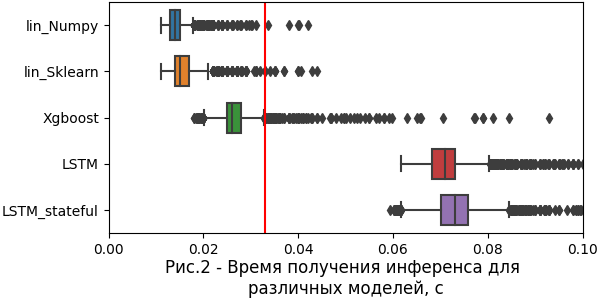

In [462]:
# Загрузка сохраненного списка
times =  pd.read_csv(os.path.join(PATH, 'times.csv'), index_col=0) 
#times['new_stateful'] = ts_list[:7244]

times = times.rename(columns={
    'manual_reg':'lin_Numpy', 
    'Lin_reg':'lin_Sklearn', 
    'xgb':'Xgboost', 
    'LSTM': 'LSTM', #'нейросеть BN + LSTM(100) + d/o', 
    'model_stateful':'LSTM_stateful'
})

fig, ax = plt.subplots(1,1, figsize=(6,3))
fig = sns.boxplot(data=times, orient='h', width=0.65)
ax.set_xlim(0,0.1)
ax.axvline(0.033, color='r')#, color='r', ls=':')
ax.set_title('Рис.2 - Время получения инференса для \nразличных моделей, c', y=-0.3)
plt.tight_layout(pad=0.15);
#plt.subplots_adjust(right=1.1)

plt.savefig(f'../figures/fig_2.png')

times.agg(['mean','std']).round(3)*1000

In [800]:
# Проверка совпадений номеров предсказаний, которые предсказываются дольше 33 мс
# times[(times['xgb']>0.033) & (times['Lin_reg']>0.033)][['xgb','xgb1']]

Empty DataFrame
Columns: [xgb, xgb1]
Index: []

## Inference

### Offline (dataset)

In [352]:
df_sim = gestures_test.iloc[2000:2500]
print(df_sim.shape)

TIMEOUT = 1 # 0.33
DEBUG = True
    
i = 0
ts_diff = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))
ts_old = time.time()
y_previous = None

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}

# # loading linear regression model
# with open(os.path.join(config.PATH_MODEL+'lin.pkl'), 'rb') as f:
#     saved_model = pickle.load(f)


# # loading xgb model
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     model_xgb = pickle.load(f)

saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))


while True:    
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
        
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed, saved_model)
    
    # inference for manual linear regression
    #y_predicted = get_predict(sample_preprocessed, weights)
  
    # [Inference Postprocessing]
    y_postprocessed      = postprocessing(y_predicted, prev=y_previous) #, preproc_coef=0.2
  
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 256, TS: 2213631


#### Сохранение списка из "комманд" различных моделей для сравнения с таргетом

In [464]:
#commands = dict()
#commands_df['LSTM']=pd.DataFrame({'LSTM':np.array(y_dct['y_commands']).flatten()})

#commands_df.head(2)

#commands_df.to_csv('../data/commands.csv')

Xgboost  lin_Sklearn  lin_Numpy  LSTM
0       67           68         71    78
1       73           75         77    80

In [1030]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (500, 50)
enc_sample.shape = (500, 6)
sample_preprocessed.shape = (500, 100)
y_predicted.shape = (500, 5)
y_postprocessed.shape = (500, 5)
y_commands.shape = (500, 5)


In [57]:
np.unique(y_dct['y_commands'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [361]:
# Чтение списка комманд
commands_df =  pd.read_csv(os.path.join(PATH, 'commands.csv'), index_col=0) 

lin_Numpy = commands_df['lin_Numpy'].values.reshape(500,5)
lin_Sklearn = commands_df['lin_Sklearn'].values.reshape(500,5)
Xgboost = commands_df['Xgboost'].values.reshape(500,5)
LSTMs = commands_df['LSTM'].values.reshape(500,5)

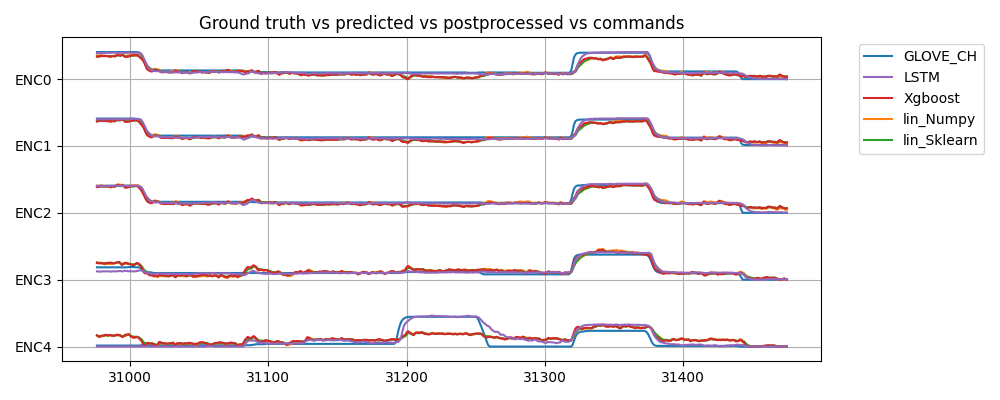

In [390]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='C0', label='GLOVE_CH')#, label='GLOVE_CH'
ax.plot(xticks, lin_Numpy + dist, c='C1', label='lin_Numpy')#
ax.plot(xticks,  lin_Sklearn + dist, c='C2', label='lin_Sklearn') #
ax.plot(xticks,   Xgboost + dist, c='C3', label ='Xgboost') #
ax.plot(xticks,   LSTMs + dist, c='C4', label ='LSTM')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 